# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.393556
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.219209 analytic: 1.219209, minus: 0.000000, relative error: 3.678587e-09
numerical: -1.876844 analytic: -1.876844, minus: 0.000000, relative error: 2.535561e-08
numerical: 0.077700 analytic: 0.077700, minus: 0.000000, relative error: 3.459933e-07
numerical: 1.551570 analytic: 1.551570, minus: 0.000000, relative error: 4.745153e-08
numerical: 0.234006 analytic: 0.234006, minus: 0.000000, relative error: 2.089935e-07
numerical: 3.783778 analytic: 3.783778, minus: 0.000000, relative error: 3.513620e-09
numerical: -0.398705 analytic: -0.398705, minus: 0.000000, relative error: 1.376639e-07
numerical: -2.743039 analytic: -2.743038, minus: 0.000000, relative error: 9.551210e-09
numerical: 2.040886 analytic: 2.040886, minus: 0.000000, relative error: 1.880402e-09
numerical: 0.976208 analytic: 0.976208, minus: 0.000000, relative error: 4.046642e-08
numerical: 0.437778 analytic: 0.437778, minus: 0.000000, relative error: 5.915633e-08
numerical: 1.107123 analytic: 1.107123, minus: 0

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.393556e+00 computed in 0.097956s
vectorized loss: 2.393556e+00 computed in 0.005389s
Loss difference: 0.000000
Gradient difference: 0.000000


lr: 0.01 reg: 10.0
iteration 0 / 1500: loss 5.289231


cs231n/classifiers/softmax.py:81: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax[arange, y]))


iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
tr_acc: 0.198408163265 val_acc: 0.198


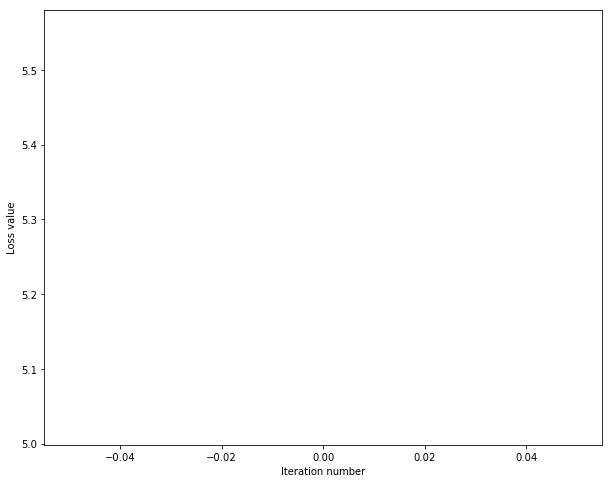

lr: 0.01 reg: 50000.0
iteration 0 / 1500: loss 776.506134


cs231n/classifiers/softmax.py:83: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
cs231n/classifiers/softmax.py:83: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


iteration 100 / 1500: loss inf


cs231n/classifiers/softmax.py:79: RuntimeWarning: overflow encountered in subtract
  scores -= np.reshape(np.max(scores, axis=1), (-1, 1)) # for numeric stability
cs231n/classifiers/softmax.py:79: RuntimeWarning: invalid value encountered in subtract
  scores -= np.reshape(np.max(scores, axis=1), (-1, 1)) # for numeric stability
cs231n/classifiers/softmax.py:88: RuntimeWarning: overflow encountered in multiply
  dW += reg * W


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


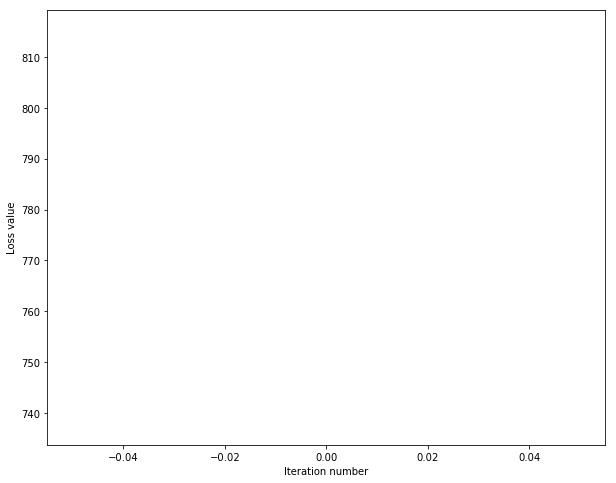

lr: 0.01 reg: 100000.0
iteration 0 / 1500: loss 1553.067639
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


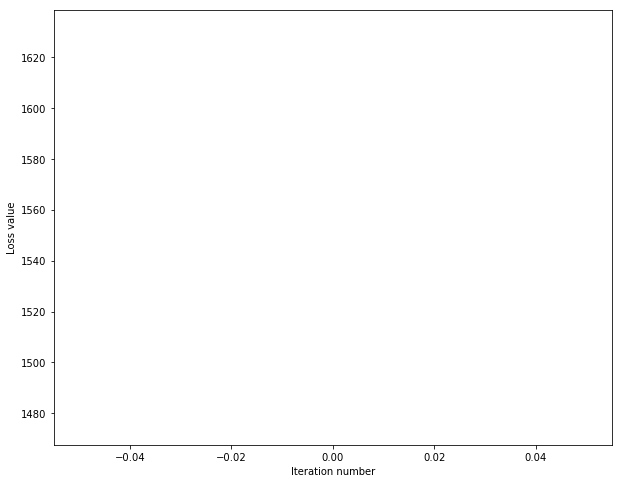

lr: 0.01 reg: 10000000.0
iteration 0 / 1500: loss 154292.575526
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


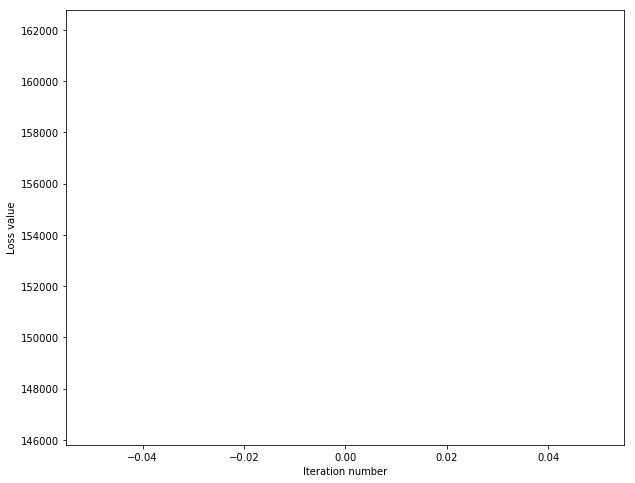

lr: 1e-07 reg: 10.0
iteration 0 / 1500: loss 5.636658
iteration 100 / 1500: loss 4.008629
iteration 200 / 1500: loss 3.802586
iteration 300 / 1500: loss 3.687310
iteration 400 / 1500: loss 3.462814
iteration 500 / 1500: loss 3.015980
iteration 600 / 1500: loss 3.099246
iteration 700 / 1500: loss 3.120053
iteration 800 / 1500: loss 2.980890
iteration 900 / 1500: loss 3.068273
iteration 1000 / 1500: loss 2.972373
iteration 1100 / 1500: loss 2.997777
iteration 1200 / 1500: loss 2.747265
iteration 1300 / 1500: loss 2.995119
iteration 1400 / 1500: loss 2.740648
tr_acc: 0.245653061224 val_acc: 0.245


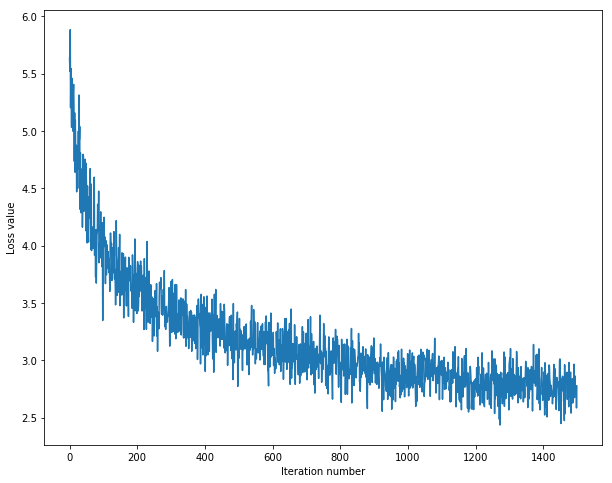

lr: 1e-07 reg: 50000.0
iteration 0 / 1500: loss 779.234903
iteration 100 / 1500: loss 285.920448
iteration 200 / 1500: loss 105.835027
iteration 300 / 1500: loss 40.139709
iteration 400 / 1500: loss 15.980081
iteration 500 / 1500: loss 7.162604
iteration 600 / 1500: loss 3.939460
iteration 700 / 1500: loss 2.761376
iteration 800 / 1500: loss 2.380422
iteration 900 / 1500: loss 2.184209
iteration 1000 / 1500: loss 2.132734
iteration 1100 / 1500: loss 2.041574
iteration 1200 / 1500: loss 2.012120
iteration 1300 / 1500: loss 2.058650
iteration 1400 / 1500: loss 2.038057
tr_acc: 0.332387755102 val_acc: 0.352


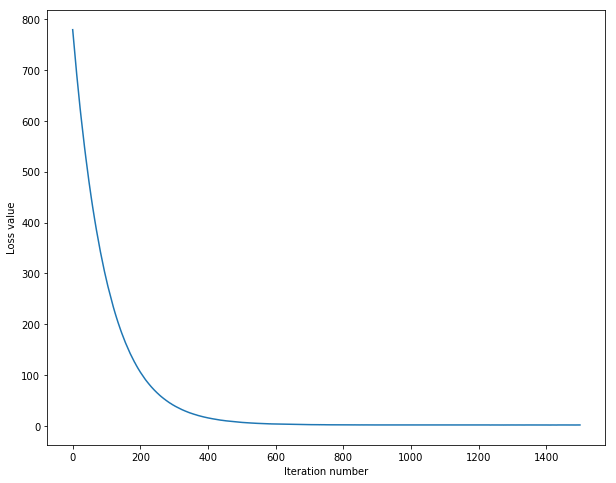

lr: 1e-07 reg: 100000.0
iteration 0 / 1500: loss 1541.780613
iteration 100 / 1500: loss 207.875239
iteration 200 / 1500: loss 29.630574
iteration 300 / 1500: loss 5.825760
iteration 400 / 1500: loss 2.635971
iteration 500 / 1500: loss 2.228407
iteration 600 / 1500: loss 2.144114
iteration 700 / 1500: loss 2.160040
iteration 800 / 1500: loss 2.135676
iteration 900 / 1500: loss 2.183766
iteration 1000 / 1500: loss 2.153122
iteration 1100 / 1500: loss 2.182153
iteration 1200 / 1500: loss 2.160779
iteration 1300 / 1500: loss 2.145940
iteration 1400 / 1500: loss 2.145525
tr_acc: 0.306653061224 val_acc: 0.314


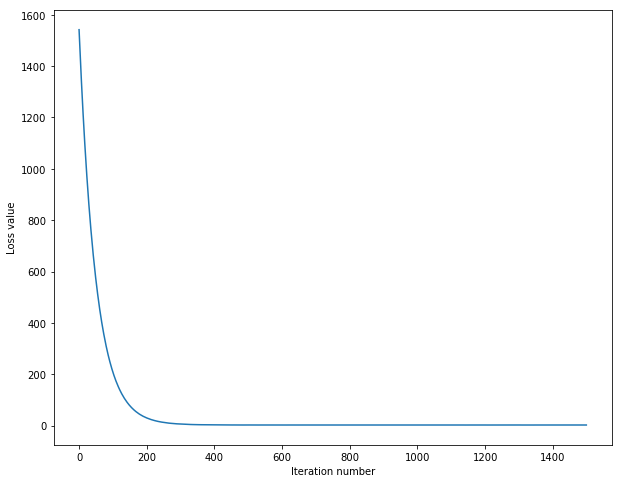

lr: 1e-07 reg: 10000000.0
iteration 0 / 1500: loss 153010.254239
iteration 100 / 1500: loss 2.302444
iteration 200 / 1500: loss 2.300928
iteration 300 / 1500: loss 2.305559
iteration 400 / 1500: loss 2.298957
iteration 500 / 1500: loss 2.300848
iteration 600 / 1500: loss 2.301473
iteration 700 / 1500: loss 2.300110
iteration 800 / 1500: loss 2.300994
iteration 900 / 1500: loss 2.298900
iteration 1000 / 1500: loss 2.301166
iteration 1100 / 1500: loss 2.300240
iteration 1200 / 1500: loss 2.302284
iteration 1300 / 1500: loss 2.301318
iteration 1400 / 1500: loss 2.302804
tr_acc: 0.203428571429 val_acc: 0.203


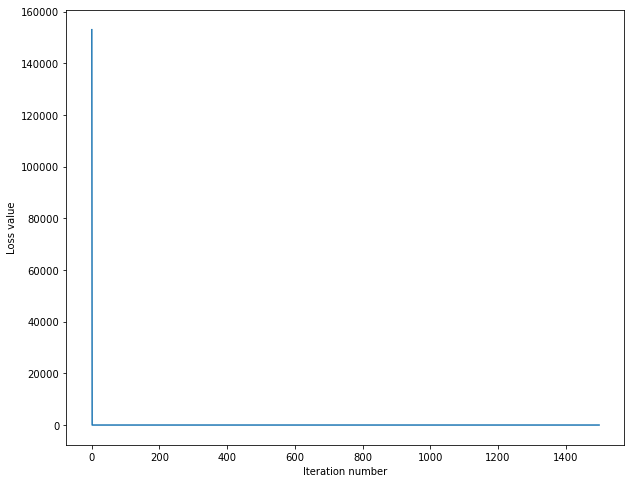

lr: 5e-07 reg: 10.0
iteration 0 / 1500: loss 5.220748
iteration 100 / 1500: loss 3.199803
iteration 200 / 1500: loss 2.659652
iteration 300 / 1500: loss 2.643698
iteration 400 / 1500: loss 2.661660
iteration 500 / 1500: loss 2.502268
iteration 600 / 1500: loss 2.545346
iteration 700 / 1500: loss 2.443139
iteration 800 / 1500: loss 2.270182
iteration 900 / 1500: loss 2.333766
iteration 1000 / 1500: loss 2.362045
iteration 1100 / 1500: loss 2.352471
iteration 1200 / 1500: loss 2.360386
iteration 1300 / 1500: loss 2.357722
iteration 1400 / 1500: loss 2.352999
tr_acc: 0.321530612245 val_acc: 0.323


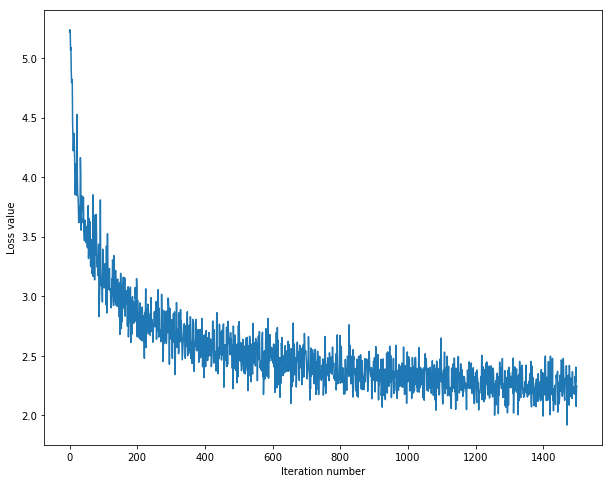

lr: 5e-07 reg: 50000.0
iteration 0 / 1500: loss 771.813426
iteration 100 / 1500: loss 6.880155
iteration 200 / 1500: loss 2.137773
iteration 300 / 1500: loss 2.015003
iteration 400 / 1500: loss 2.019962
iteration 500 / 1500: loss 2.112155
iteration 600 / 1500: loss 2.091390
iteration 700 / 1500: loss 2.080366
iteration 800 / 1500: loss 2.117313
iteration 900 / 1500: loss 2.055168
iteration 1000 / 1500: loss 2.050764
iteration 1100 / 1500: loss 2.081008
iteration 1200 / 1500: loss 2.068457
iteration 1300 / 1500: loss 2.083620
iteration 1400 / 1500: loss 2.129623
tr_acc: 0.335 val_acc: 0.339


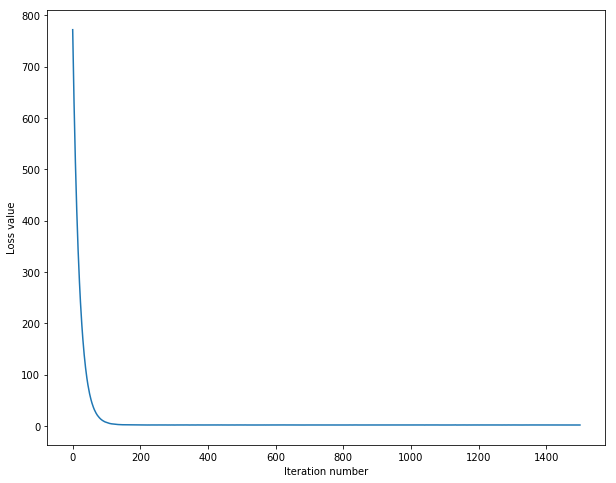

lr: 5e-07 reg: 100000.0
iteration 0 / 1500: loss 1512.855564
iteration 100 / 1500: loss 2.271174
iteration 200 / 1500: loss 2.162191
iteration 300 / 1500: loss 2.151608
iteration 400 / 1500: loss 2.140850
iteration 500 / 1500: loss 2.143986
iteration 600 / 1500: loss 2.165741
iteration 700 / 1500: loss 2.145241
iteration 800 / 1500: loss 2.159507
iteration 900 / 1500: loss 2.132633
iteration 1000 / 1500: loss 2.168719
iteration 1100 / 1500: loss 2.135693
iteration 1200 / 1500: loss 2.151553
iteration 1300 / 1500: loss 2.169052
iteration 1400 / 1500: loss 2.152262
tr_acc: 0.305632653061 val_acc: 0.315


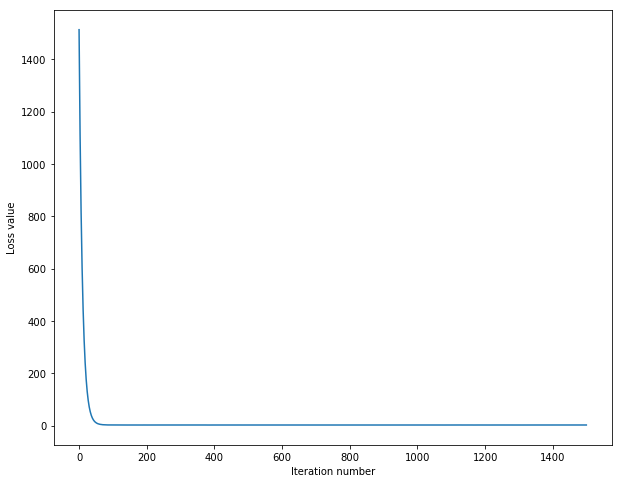

lr: 5e-07 reg: 10000000.0
iteration 0 / 1500: loss 153520.907584
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


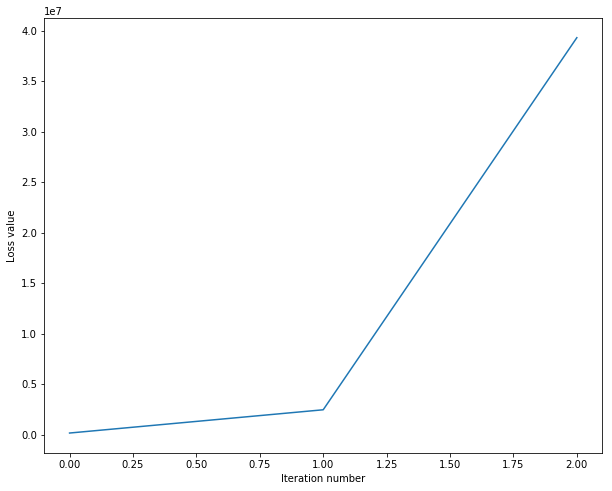

lr: 1e-10 reg: 10.0
iteration 0 / 1500: loss 5.049203
iteration 100 / 1500: loss 5.167363
iteration 200 / 1500: loss 5.662768
iteration 300 / 1500: loss 5.101730
iteration 400 / 1500: loss 5.117160
iteration 500 / 1500: loss 5.186227
iteration 600 / 1500: loss 4.822161
iteration 700 / 1500: loss 4.776363
iteration 800 / 1500: loss 5.372164
iteration 900 / 1500: loss 5.192729
iteration 1000 / 1500: loss 4.996396
iteration 1100 / 1500: loss 5.060606
iteration 1200 / 1500: loss 5.065529
iteration 1300 / 1500: loss 5.017760
iteration 1400 / 1500: loss 5.266160
tr_acc: 0.111183673469 val_acc: 0.11


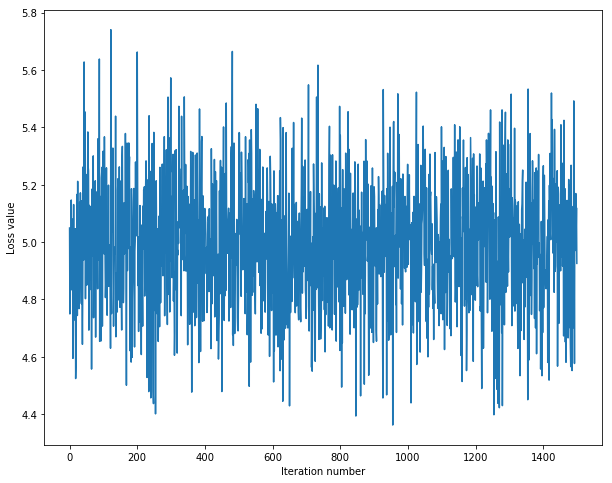

lr: 1e-10 reg: 50000.0
iteration 0 / 1500: loss 770.603503
iteration 100 / 1500: loss 770.364799
iteration 200 / 1500: loss 768.997547
iteration 300 / 1500: loss 768.553317
iteration 400 / 1500: loss 767.870623
iteration 500 / 1500: loss 766.941271
iteration 600 / 1500: loss 766.293659
iteration 700 / 1500: loss 765.472403
iteration 800 / 1500: loss 764.835491
iteration 900 / 1500: loss 763.836298
iteration 1000 / 1500: loss 763.508731
iteration 1100 / 1500: loss 762.262892
iteration 1200 / 1500: loss 761.800653
iteration 1300 / 1500: loss 760.718824
iteration 1400 / 1500: loss 760.640222
tr_acc: 0.0785102040816 val_acc: 0.091


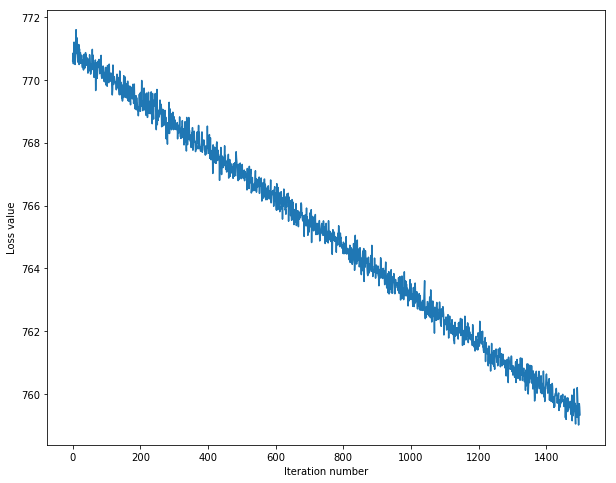

lr: 1e-10 reg: 100000.0
iteration 0 / 1500: loss 1551.014315
iteration 100 / 1500: loss 1547.773998
iteration 200 / 1500: loss 1544.721206
iteration 300 / 1500: loss 1541.140206
iteration 400 / 1500: loss 1538.282218
iteration 500 / 1500: loss 1535.732573
iteration 600 / 1500: loss 1533.216049
iteration 700 / 1500: loss 1529.466512
iteration 800 / 1500: loss 1527.170876
iteration 900 / 1500: loss 1523.521210
iteration 1000 / 1500: loss 1520.586388
iteration 1100 / 1500: loss 1516.995667
iteration 1200 / 1500: loss 1514.412112
iteration 1300 / 1500: loss 1511.194437
iteration 1400 / 1500: loss 1508.379724
tr_acc: 0.112448979592 val_acc: 0.106


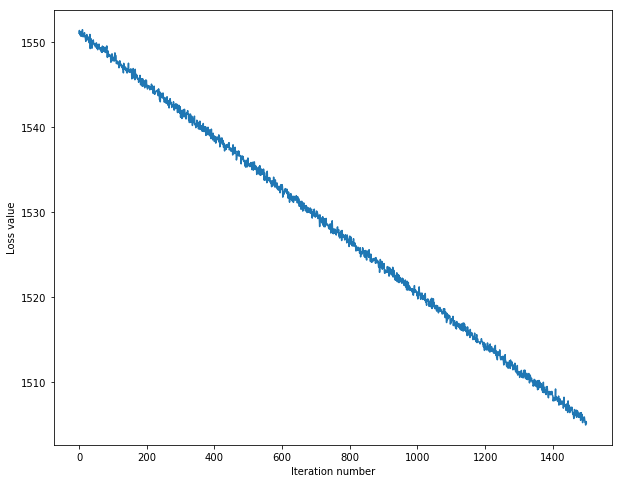

lr: 1e-10 reg: 10000000.0
iteration 0 / 1500: loss 154710.409782
iteration 100 / 1500: loss 126654.193536
iteration 200 / 1500: loss 103685.095578
iteration 300 / 1500: loss 84881.674139
iteration 400 / 1500: loss 69488.701388
iteration 500 / 1500: loss 56887.063690
iteration 600 / 1500: loss 46570.828918
iteration 700 / 1500: loss 38125.439625
iteration 800 / 1500: loss 31211.650272
iteration 900 / 1500: loss 25551.712757
iteration 1000 / 1500: loss 20918.196892
iteration 1100 / 1500: loss 17125.160644
iteration 1200 / 1500: loss 14019.744304
iteration 1300 / 1500: loss 11477.615575
iteration 1400 / 1500: loss 9396.467964
tr_acc: 0.111326530612 val_acc: 0.103


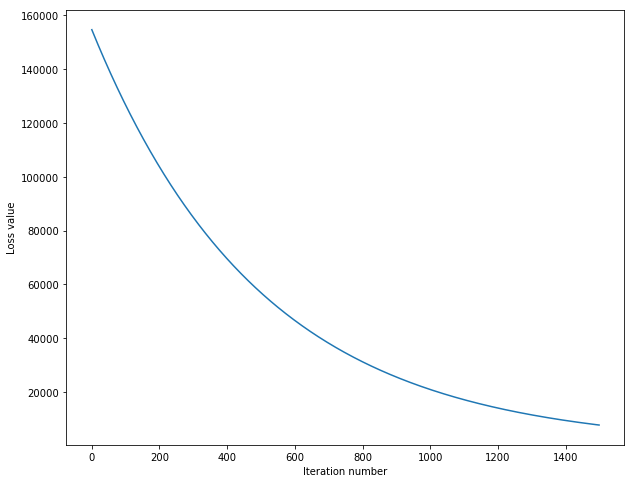

lr 1.000000e-10 reg 1.000000e+01 train accuracy: 0.111184 val accuracy: 0.110000
lr 1.000000e-10 reg 5.000000e+04 train accuracy: 0.078510 val accuracy: 0.091000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.112449 val accuracy: 0.106000
lr 1.000000e-10 reg 1.000000e+07 train accuracy: 0.111327 val accuracy: 0.103000
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.245653 val accuracy: 0.245000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.332388 val accuracy: 0.352000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.306653 val accuracy: 0.314000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.203429 val accuracy: 0.203000
lr 5.000000e-07 reg 1.000000e+01 train accuracy: 0.321531 val accuracy: 0.323000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.335000 val accuracy: 0.339000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.305633 val accuracy: 0.315000
lr 5.000000e-07 reg 1.000000e+07 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-02 reg 1.000000

In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-2, 1e-7, 5e-7, 1e-10]
regularization_strengths = [1e1, 5e4, 1e5, 1e7]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
from cs231n.classifiers import Softmax
for lr in learning_rates:
    for reg in regularization_strengths:
        print "lr:", lr, "reg:", reg
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, lr, reg, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train_pred == y_train)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val_pred == y_val)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
        print 'tr_acc:', train_acc, 'val_acc:', val_acc
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.341000


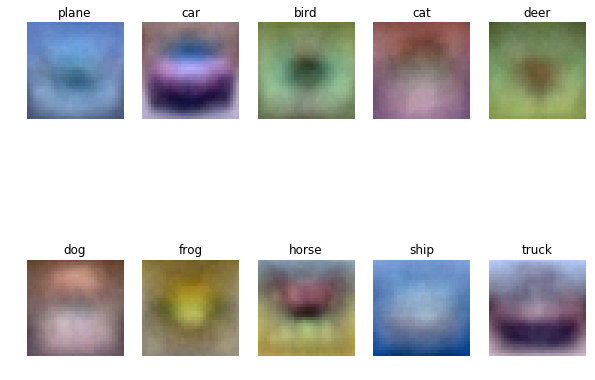

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])